## Alternative aproach to MGA  

In [1]:
import pypsa
import pandas as pd

In this section a series of coppies of seperate disconected busses/networks is generated. They are all in the same PyPSA model, but will not influence each other

In [2]:
network = pypsa.Network()
nr_of_networks = 3
# Create an empty network.
network.set_snapshots(range(2))
# Looping over the number of networks to be created,
# and altering the bus name and the generator names.
# The last number in the generator name indicates which instance
# of the networks they belong to
for i in range(nr_of_networks):
    
    # Add a bus to the network.
    bus_nr = 'bus'+str(i+1)
    network.add("Bus",bus_nr,x=i,y=i%2)

    # Add a coal power plant to the bus.
    network.add("Generator",'coal'+str(i+1),bus=bus_nr,
           type = 'coal',
           committable=True,
           p_min_pu=0.2,
           marginal_cost=20,
           p_nom_extendable=False,
           p_nom=4000)

    # Add a gas power plant to the bus.
    network.add("Generator",'gas'+str(i+1),bus=bus_nr,
           type = 'gas',
           committable=True,
           marginal_cost=15,
           p_min_pu=0,
           p_nom_extendable=True,
           p_nom_max=4000)

    # Add load to the bus.
    network.add("Load",'load'+str(i+1),bus=bus_nr,p_set=[1200,800])

(<matplotlib.collections.PathCollection at 0x24079a3ccf8>,)

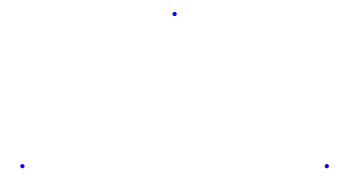

In [3]:
network.plot()

As with the regular MGA aproach the network is first solved without the new objective function

In [4]:
    # Initial solution of network, with non MGA objective function 
    network.lopf(network.snapshots,solver_name='gurobi')

INFO:pypsa.pf:Slack bus for sub-network 0 is bus1
INFO:pypsa.pf:Slack bus for sub-network 1 is bus2
INFO:pypsa.pf:Slack bus for sub-network 2 is bus3
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['gas1', 'gas2', 'gas3'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x28
  Lower bound: 90000.0
  Upper bound: 90000.0
  Number of objectives: 1
  Number of constraints: 37
  Number of variables: 28
  Number of binary variables: 6
  Number of integer variables: 6
  Number of continuous variables: 22
  Number of nonzeros: 61
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (s

('ok', 'optimal')

The initial solution will alway contain a set of identical networks. The last number in the generators describe which network they belong to

In [5]:
network.generators_t.p

,coal1,gas1,coal2,gas2,coal3,gas3
0,0.0,1200.0,0.0,1200.0,0.0,1200.0
1,-0.0,800.0,-0.0,800.0,-0.0,800.0


In [6]:
    # Saving the value of the old objective function.
    old_objective_value = network.model.objective()
    old_objective_value

90000.0

## An alternative objective function 

In this alternative aproach, the MGA objective function seeks to maximize the distance between a number $N$ of networks with $K$ variables. The distance between the networks can be described with the squared euqlidian distance for an $n$ dimentional vector. 

$ d = \sum_{i=1}^n{(x_{i}-x_{i})^2} $

By summing the distance from each network to all other networks, an expression describing the distinction between the networks is found. The following objective function will try to maximize the distance between all networks:

$N$ : Number of independent networks 

$K$ : Number of variables in each network

$x$ : 2D vector containing all variables. 1st index specifies the variable and 2nd index specifies the network

$ p= - \frac{1}{2}  \sum_i^N{\sum_j^N{\sum_k^K{(x_{k,i}-x_{k,j})^2}}}  $ 

The drawback is that the objective function is now a square function, increasing computation time, however gurobi is capable of handeling it, at least for smaller energy systems

In [7]:
def extra_functionality(network, snapshots,  MGA_slack = 0.05):
    # Defining exstra functionality, that updates the objective function of the network
    # Default value for MGA_slack is 0.05 if nothing else is specified 
    import pyomo.environ as pyomo_env

    
    # Number of networks
    N = int(list(network.generators_t.p.columns)[-1][-1]) 
    # Generating a list of variables sorted after their variable index and network number
    # First index: Variable nr
    # Second index: Network number    
    gen_p_list = [[] for i in range(N)]
    for gen_p in network.model.generator_p:
        gen_p_network_idx = int(gen_p[0][-1])-1
        gen_p_list[gen_p_network_idx].append(gen_p)
    # Number of variables in each network
    K = len(gen_p_list[0]) 

    # Creating the MGA objective function
    MGA_objective = 0

    for i in range(N):
        for j in range(N):
            for k in range(K):
                if i < j:
                    gen_p1 = network.model.generator_p[gen_p_list[i][k]]
                    gen_p2 = network.model.generator_p[gen_p_list[j][k]]
                    MGA_objective += (gen_p1**2 + gen_p2**2 - 2*gen_p1*gen_p2 )
    # Changing sign of objective function to make it a minimization problem
    MGA_objective = - MGA_objective 
    print (MGA_objective)
    
    # Adding new MGA objective function to network 
    network.model.mga_objective = pyomo_env.Objective(expr=MGA_objective)
    # Deactivate the old objective function and activate the MGA objective function.
    network.model.objective.deactivate()
    network.model.mga_objective.activate()
    # Add the MGA slack constraint.
    network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
                                          (1 + MGA_slack) * old_objective_value)



In [8]:
MGA_slack = 0.09
#Solve network with updated objective function
network.lopf(network.snapshots,\
             solver_name='gurobi',\
             extra_functionality=lambda network,\
             snapshots: extra_functionality(network, snapshots, MGA_slack),
             solver_options = {'psdtol':10,'presolve':-1}) 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus1
INFO:pypsa.pf:Slack bus for sub-network 1 is bus2
INFO:pypsa.pf:Slack bus for sub-network 2 is bus3
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['gas1', 'gas2', 'gas3'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


- (generator_p[coal1,0]**2 + generator_p[coal2,0]**2 - 2*generator_p[coal1,0]*generator_p[coal2,0] + generator_p[coal1,1]**2 + generator_p[coal2,1]**2 - 2*generator_p[coal1,1]*generator_p[coal2,1] + generator_p[gas1,0]**2 + generator_p[gas2,0]**2 - 2*generator_p[gas1,0]*generator_p[gas2,0] + generator_p[gas1,1]**2 + generator_p[gas2,1]**2 - 2*generator_p[gas1,1]*generator_p[gas2,1] + generator_p[coal1,0]**2 + generator_p[coal3,0]**2 - 2*generator_p[coal1,0]*generator_p[coal3,0] + generator_p[coal1,1]**2 + generator_p[coal3,1]**2 - 2*generator_p[coal1,1]*generator_p[coal3,1] + generator_p[gas1,0]**2 + generator_p[gas3,0]**2 - 2*generator_p[gas1,0]*generator_p[gas3,0] + generator_p[gas1,1]**2 + generator_p[gas3,1]**2 - 2*generator_p[gas1,1]*generator_p[gas3,1] + generator_p[coal2,0]**2 + generator_p[coal3,0]**2 - 2*generator_p[coal2,0]*generator_p[coal3,0] + generator_p[coal2,1]**2 + generator_p[coal3,1]**2 - 2*generator_p[coal2,1]*generator_p[coal3,1] + generator_p[gas2,0]**2 + generato

INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x28
  Lower bound: 11726820.0
  Upper bound: -5249600.0
  Number of objectives: 1
  Number of constraints: 38
  Number of variables: 28
  Number of binary variables: 6
  Number of integer variables: 6
  Number of continuous variables: 22
  Number of nonzeros: 73
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimal

('ok', 'optimal')

In [9]:
network.generators_t.p

,coal1,gas1,coal2,gas2,coal3,gas3
0,0.0,1200.0,0.0,1200.0,820.0,380.0
1,0.0,800.0,800.0,0.0,0.0,800.0


In [10]:
print(network.model.objective())

98100.0
